Natural Language Processing (NLP) has witnessed transformative advancements, thanks to the integration of Neural Networks (NN). Leveraging the expressive capabilities of deep learning, NN has proven to be a game-changer in understanding and extracting meaning from vast amounts of textual data. In this section, we delve into the advantages that NN brings to NLP tasks:

**Advantages of Neural Networks in NLP:**
- **Semantic Understanding:** NN excels in capturing intricate semantic
relationships within text, enabling models to comprehend context, nuances, and subtleties in language.
- **Feature Learning:** The hierarchical representation learning in NN allows models to automatically discover relevant features from raw text, reducing the need for manual feature engineering.
- **Contextual Analysis:** Unlike traditional methods, NN models can consider the entire context of a sentence or document, offering improved contextual analysis crucial for understanding language intricacies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer 
# convert a collection of text documents to a matrix of token counts
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

from nltk.metrics import edit_distance
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_colwidth', None)  

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data
df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')

In [3]:
df.dropna(inplace = True)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [4]:
# Remove the punctuation from the questions and apply some filters to the data
import string
from multiprocessing import Pool, cpu_count

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def convert_to_lower(text):
    return text.lower()

def remove_contractions(text):
    # Define a list of common contractions and their expanded forms
    contractions = {
        "don't": "do not", 
        "won't": "will not", 
        "can't": "cannot",
        # Add more contractions and their expansions as needed
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text

def replace_currency_symbols(text):
    # Define a dictionary mapping currency symbols to currency names
    currency_symbols = {"$": "USD", "€": "EUR", "£": "GBP",}
    for symbol, currency_name in currency_symbols.items():
        text = text.replace(symbol, currency_name)
    return text

def remove_hyperlinks(text):
    # Remove URLs and hyperlinks using regular expression
    text = re.sub(r'http\S+', '', text)
    return text

def remove_html_tags(text):
    # Remove HTML tags using regular expression
    text = re.sub(r'<.*?>', '', text)
    return text

def process_column(column):
    with Pool(cpu_count()) as pool:
        processed_column = pool.map(remove_punctuation, column)
        processed_column = pool.map(convert_to_lower, processed_column)
        processed_column = pool.map(remove_contractions, processed_column)
        processed_column = pool.map(replace_currency_symbols, processed_column)
        processed_column = pool.map(remove_hyperlinks, processed_column)
        processed_column = pool.map(remove_html_tags, processed_column)
    return processed_column

In [5]:
columns_to_drop = ['id', 'qid1', 'qid2']
df = df.drop(columns=columns_to_drop, axis=1)
df['question1'] = process_column(df['question1'])
df['question2'] = process_column(df['question2'])
df.head()

,question1,question2,is_duplicate
0,what is the step by step guide to invest in share market in india,what is the step by step guide to invest in share market,0
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government stole the kohinoor kohinoor diamond back,0
2,how can i increase the speed of my internet connection while using a vpn,how can internet speed be increased by hacking through dns,0
3,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divided by 2423,0
4,which one dissolve in water quikly sugar salt methane and carbon di oxide,which fish would survive in salt water,0


# 1. Pretrained Word Embeddings

Ý tưởng cơ bản của word2vec có thể được gói gọn trong các ý sau:

- Hai từ xuất hiện trong những văn cảnh giống nhau thường có ý nghĩa gần với nhau.
- Ta có thể đoán được một từ nếu biết các từ xung quanh nó trong câu. 

Ví dụ, với câu “Hà Nội là … của Việt Nam” thì từ trong dấu ba chấm khả năng cao là “thủ đô”. Với câu hoàn chỉnh “Hà Nội là thủ đô của Việt Nam”, mô hình word2vec sẽ xây dựng ra embeding của các từ sao cho xác suất để từ trong dấu ba chấm là “thủ đô” là cao nhất.
Trong ví dụ này, từ “thủ đô” đang được xét và được gọi là *target word* hay *từ đích*. Những từ xung quanh nó được gọi là *context words* hay *từ ngữ cảnh*. Với mỗi từ đích trong một câu của cơ sở dữ liệu, các từ ngữ cảnh được định nghĩa là các từ trong cùng câu có vị trí cách từ đích một khoảng không quá C/2 với C là một số tự nhiên dương. Như vậy, với mỗi từ đích, ta sẽ có một bộ không quá C từ ngữ cảnh.

Xét ví dụ sau đây với câu tiếng Anh: **“The quick brown fox jump over the lazy dog”** với C = 4.

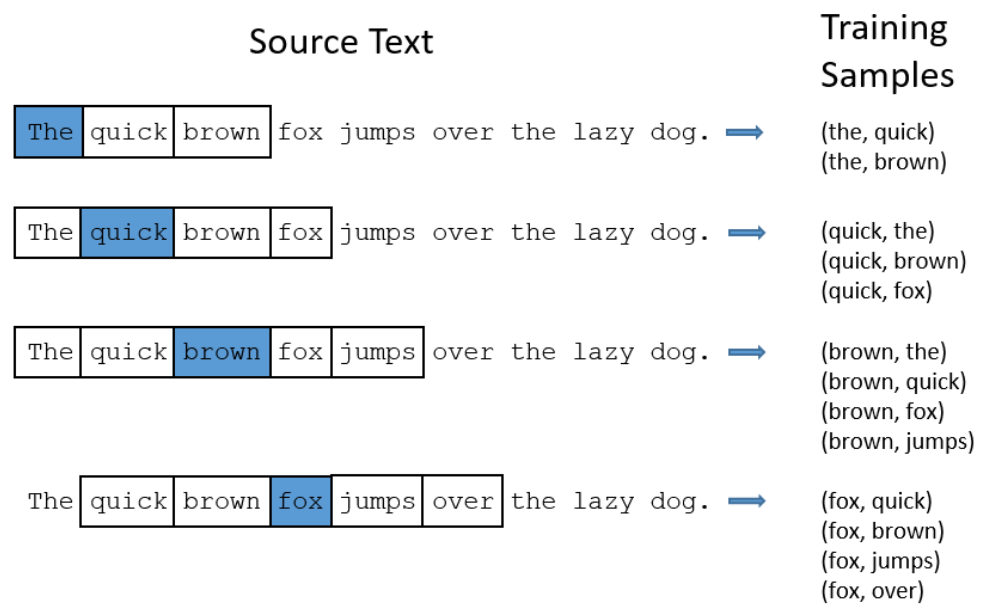

Khi “the” là từ đích, ta có cặp dữ liệu huấn luyện là (the, quick) và (the, brown). Khi “brown” là từ đích, ta có cặp dữ liệu huấn luyện là (brown, the), (brown, quick), (brown, fox) và (brown, jumps).

Word2vec định nghĩa hai embedding vector cùng chiều cho mỗi từ w trong từ điển. Khi nó là một từ đích, embedding vector của nó là u; khi nó là một từ ngữ cảnh, embedding của nó là v. Sở dĩ ta cần hai embedding khác nhau vì ý nghĩa của từ đó khi nó là từ đích và từ ngữ cảnh là khác nhau. Tương ứng với đó, ta có hai ma trận embedding U và V cho các từ đích và các từ ngữ cảnh.

Có hai cách khác nhau xây dựng mô hình word2vec:

- Skip-gram: Dự đoán những từ ngữ cảnh nếu biết trước từ đích.
- CBOW (Continuous Bag of Words): Dựa vào những từ ngữ cảnh để dự đoán từ đích.

In [6]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'processed_questions' contains preprocessed text
# X contains the features, which are the pairs of question1 and question2
# y contains the labels indicating whether the questions are duplicates or not
X = df[['question1', 'question2']]
y = df['is_duplicate']

# Tokenize the sentences: splitting text into individual sentences
# Mỗi câu được chia thành một danh sách các từ
# tokenized_sentences_q1 và tokenized_sentences_q2
# lần lượt là danh sách các câu được mã hóa cho question1 và question2
tokenized_sentences_q1 = X['question1'].apply(lambda x: str(x).split())
tokenized_sentences_q2 = X['question2'].apply(lambda x: str(x).split())

# Train Word2Vec model
# sentences: the input data, which is a list of tokenized sentences
# vector_size: the dimensionality of the word vectors.
# window: defines the maximum distance between the current and predicted word within a sentence
# min_count: ignores all words with a total frequency lower than this
# workers: the number of CPU cores to use for training the model
word2vec_model_q1 = Word2Vec(sentences = tokenized_sentences_q1, vector_size = 100, #mỗi từ được biểu diễn dưới dạng vector 100 chiều
                             window = 5, # Word2Vec xem xét năm từ trước và sau từ hiện tại trong câu khi huấn luyện
                             min_count = 1, # không có ngưỡng tần số từ và tất cả các từ sẽ được xem xét
                             workers = 4) # quá trình train sẽ sử dụng song song 4 lõi CPU
word2vec_model_q2 = Word2Vec(sentences = tokenized_sentences_q2, vector_size = 100,
                             window = 5, min_count = 1, workers = 4)

# Get the vector representation of a sentence
# hàm get_sentence_vector được áp dụng để thu được vectơ đặc trưng tương ứng bằng mô hình Word2Vec
def get_sentence_vector(sentence, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Create feature vectors for each question
# X_q1 và X_q2 lần lượt là các mảng NumPy chứa các vectơ đặc trưng
# cho mỗi câu trong question1 và question2
X_q1 = np.array([get_sentence_vector(sentence, word2vec_model_q1) for sentence 
                 in tokenized_sentences_q1])
X_q2 = np.array([get_sentence_vector(sentence, word2vec_model_q2) for sentence 
                 in tokenized_sentences_q2])

# Concatenate the feature vectors
# nối các vectơ đặc trưng thu được từ question1 và question2
# Việc ghép này được thực hiện để kết hợp thông tin
# từ cả hai câu hỏi thành một vectơ đặc trưng duy nhất cho mỗi điểm dữ liệu
X_combined = np.concatenate((X_q1, X_q2), axis = 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size = 0.2, random_state = 42)

# Random Forest without tuning
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Predictions
y_pred = rfc.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7949368027900764
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85     51026
           1       0.81      0.58      0.68     29832

    accuracy                           0.79     80858
   macro avg       0.80      0.75      0.76     80858
weighted avg       0.80      0.79      0.79     80858

